In [1]:
%matplotlib notebook
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, randint, uniform, choice

# Metropolis

Basic idea - start at some random location. Flip a coin to choose to move to neighbor either to the left or the right. If the neighbor is larger, always go. Otherwise, probabilistically go based on $p = p_{neig}/p_{here}$. We may start in a very low probability area, so we 'burn in' the algorithm by ignoring the the results for awhile, hoping that we end up in a more representative area of the distribution.

In [2]:
# metropolis algorithm for discrete distribution and
# explicit logic

def metropolis_d1(a, trials, burn_in, interactive=False):
    fig = plt.gcf()
    N = len(a)
    counts = np.zeros(N)
    idx = randint(0, N)  # current position

    for i in range(trials + burn_in):
        move = (idx + choice([-1, 1])) % N
    
        if a[move] >= a[idx]: #always move if new population is higher
            idx = move
        else:
            # probabilisitically move based on ratio of new/current population
            if uniform() < a[move] / a[idx]:
                idx = move

        if i >= burn_in:
            counts[idx] += 1
            if interactive:
                step = i - burn_in + 1
                if (step < 100 and step% 2 ==0) or (step < 200 and step % 10 ==0) or step % 200 == 0:
                    plt.bar(range(len(counts)), counts);
                    fig.canvas.draw()
                    plt.title('step=' + str(step))
    return counts/sum(counts)

<IPython.core.display.Javascript object>


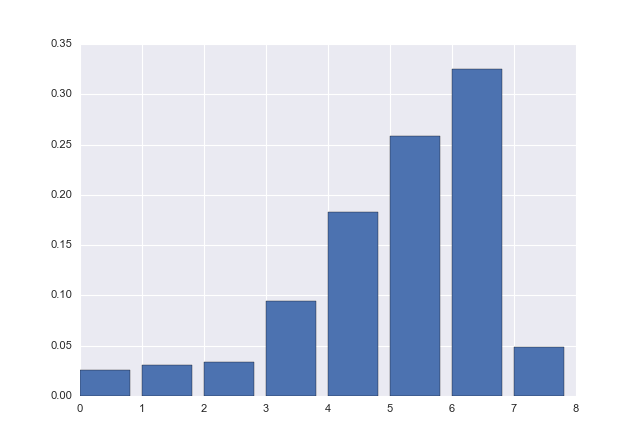

In [3]:
a = np.array([10, 10, 10, 30, 60, 90, 120, 20])
plt.figure()
counts = metropolis_d1(a, 10000, 1000)
plt.bar(range(len(counts)), counts);

Here is an interactive version that lets you see the histogram build as the Metropolis algorithm runs.

<IPython.core.display.Javascript object>


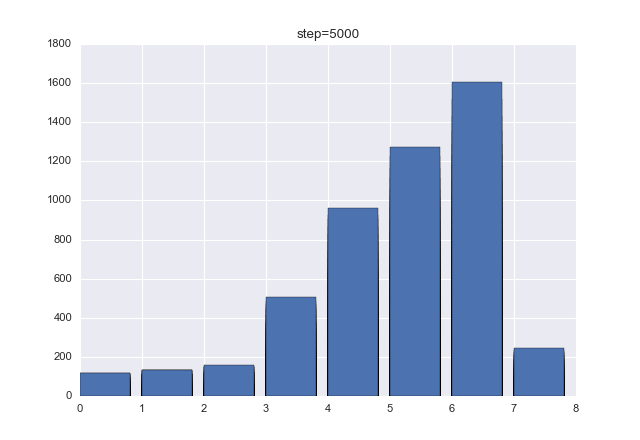

In [4]:
plt.figure()
counts = metropolis_d1(a, 5000, 500, True)

That code was explicit, but kind of dumb. If the size of the neighbor is larger than the current location than `a[move] / a[i] > 1` and thus `uniform` will always be less than it, so we can collapse the move decision down to one choice.

In [5]:
# now let's be smarter about the algorithm

def metropolis_d2(a, trials, burn_in):
    N = len(a)
    counts = np.zeros(N)
    idx = randint(0, N)  # current position

    for i in range(trials + burn_in):
        move = (idx + choice([-1, 1])) % N
        if uniform() < a[move] / a[idx]:
                idx = move

        if i >= burn_in:
            counts[idx] += 1        
    return counts/sum(counts)

<IPython.core.display.Javascript object>


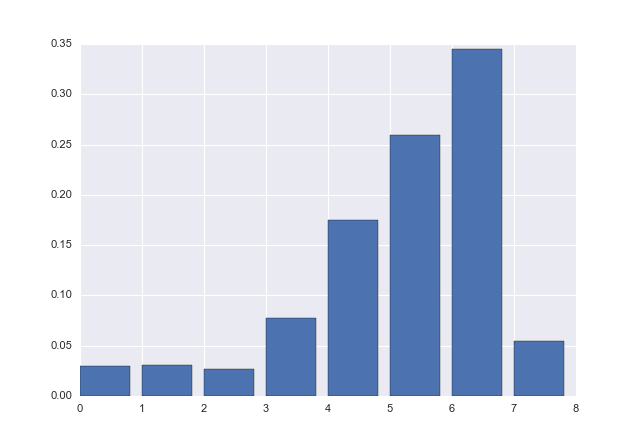

In [6]:
counts = metropolis_d2(a, 10000, 100)
plt.figure()
plt.bar(range(len(counts)), counts);
plt.show()

This is exceedingly dumb, as we can compute the distribution with

In [7]:
%precision 3
a/sum(a)

array([ 0.029,  0.029,  0.029,  0.086,  0.171,  0.257,  0.343,  0.057])

But the real use is for continuous distributions. Want to be able to jump some arbitrary distance $\mathcal N(0, \sigma)$, not just to the nearest neighbors.

In [8]:
def metropolis(prior, sigma, prob_fn, steps, burn_in):
    theta = prior
    data = []
    for i in range(steps + burn_in):
        theta_neig = theta + randn()*sigma
       
        p_neig = prob_fn(theta_neig) * theta_neig
        p_cur = max(prob_fn(theta)* theta, 1.e-80) # avoid / 0
        p_move = min(1, p_neig / p_cur)
        if uniform() < p_move:
            theta = theta_neig
        if i >= burn_in:
            data.append(theta)

    return np.array(data)

<IPython.core.display.Javascript object>


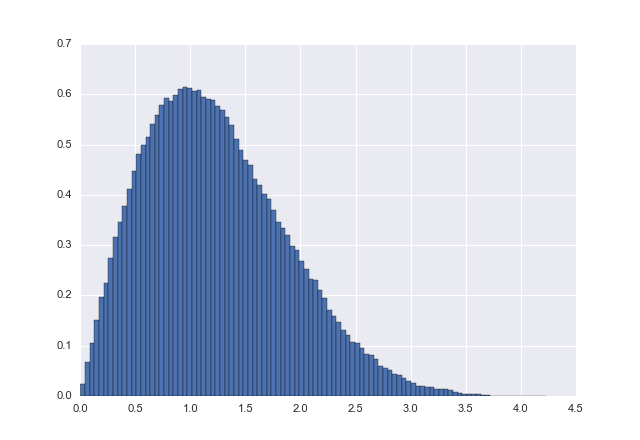

In [9]:
from math import exp, sqrt, pi

def sdev(theta):
    return exp(-theta**2/2.) / sqrt(2 * pi)

data = metropolis(0, .1, sdev, 300000, 100)
plt.figure()
plt.hist(data, 100, normed=1);

This won't work well because we are using a Gaussian to draw from the samples.

<IPython.core.display.Javascript object>


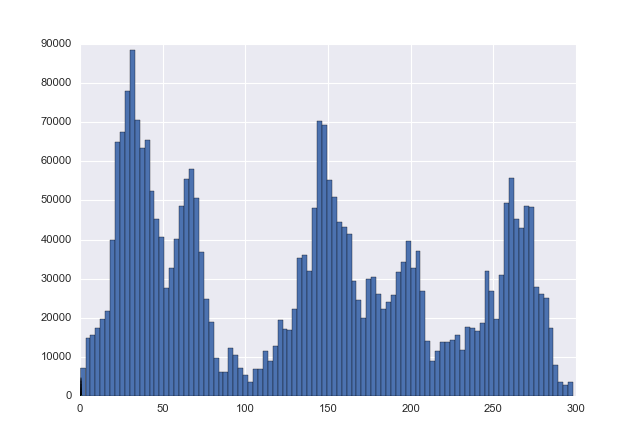

In [10]:
def flat(theta):
    return 0.01
data = metropolis(0, .1, flat, 3000000, 100)
plt.figure()
plt.hist(data, 100);

Kruschke's beta example # 7.3.1

In [11]:
from scipy.stats import beta

def prior_bern(theta, a, b):  
    if theta > 1 or theta < 0:
        return 0.
    return beta.pdf(theta, a, b)

def likelihood_bern(theta, z, N):
    if theta > 1 or theta < 0:
        return 0
    return theta**z * (1-theta)**(N-z)

def rel_prob_bern(theta, data, a, b):
    z = sum(data)
    N = len(data)    
    return likelihood_bern(theta, z, N) * prior_bern(theta, a, b)      

In [12]:
traj_len = 50000
trajectory = np.zeros(traj_len+1)

tails, heads = 6, 14
a = 1
b = 1

data = np.array([0]*tails + [1]*heads)
proposalSD = .1

# precompute all jumps and transition probabilities
# just to make things a bit faster
probs = uniform(0, 1, traj_len)

for i in range(traj_len):
    pos = trajectory[i]
    jump = pos + randn() * proposalSD
    prob_jump = rel_prob_bern(jump, data, a, b)
    prob_here = max(rel_prob_bern(pos, data, a, b), 1e-80) # avoid / 0
    prob_accept = min(1,  prob_jump / prob_here)
    if uniform() <= prob_accept:
        pos = jump
    trajectory[i+1] = pos

In [13]:
# let first 1000 be burn-in
burn_in = 1000
plt.hist(trajectory[burn_in:], 30);
bias_est = np.mean(trajectory[burn_in:])
bias= heads/(heads+tails)
             
print("bias est: {:.2f}\nbias:     {:.2f}".format(bias_est*100, bias*100))
print("std:      {:.3f}".format(np.std(trajectory[burn_in:])))

bias est: 67.94
bias:     70.00
std:      0.098


<IPython.core.display.Javascript object>


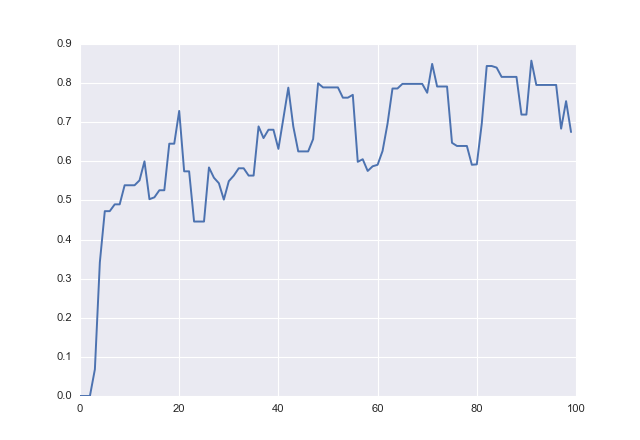

<IPython.core.display.Javascript object>


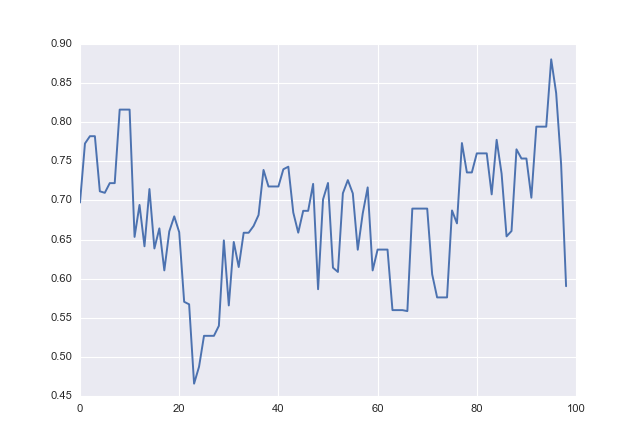

In [14]:
plt.figure()
plt.plot(trajectory[:100])
plt.figure()
plt.plot(trajectory[-100:-1]);

This is from 7.4.2 - Posterior via exact formal analysis. I'm using readable function names instead the blahhh of a big math equation like he does. The commented out line shows his equation, which of course is identical to the multiplications of the likelihoods and prior.

In [15]:
theta = np.arange(0, .99, 0.01)
N = len(theta)
n1, z1 = 8,6
n2, z2 = 7, 2
a1, b1 = 2,2
a2, b2 = 2,2

post = np.zeros((N, N))

for c, t1 in enumerate(theta):
    for r, t2 in enumerate(theta):
        #post[r, c] = t1**(z1+a1-1) * (1-t1)**(n1-z1+b1-1) * t2**(z2+a2-1) * (1-t2)**(n2-z2+b2-1)
        post[r, c] = likelihood_bern(t1, z1, n1) * likelihood_bern(t2, z2, n2) * prior_bern(t1, a1, b1) * prior_bern(t2, a2, b2)
post /= sum(sum(post))

<IPython.core.display.Javascript object>


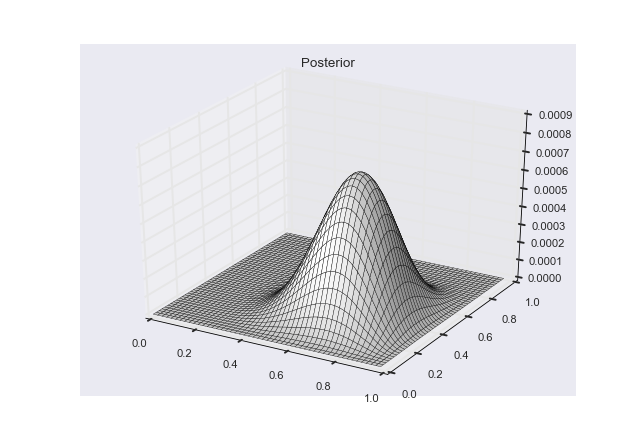

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(theta, theta)
ax.plot_surface(X, Y, post, rstride=2, cstride=2, color='w')
plt.title('Posterior')
plt.show()

Contour plot of same

<IPython.core.display.Javascript object>


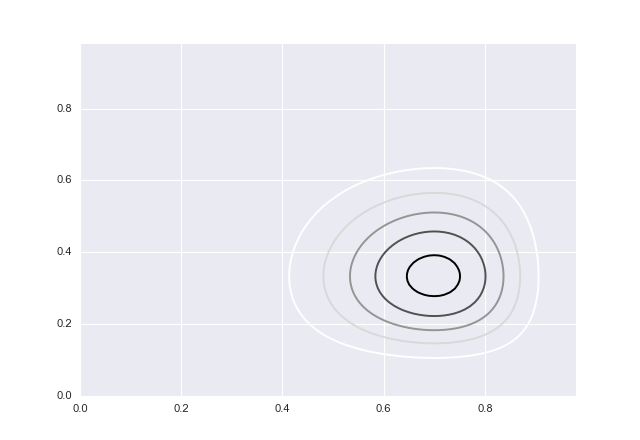

In [17]:
plt.figure()
plt.contour(X, Y, post);
plt.show()

<IPython.core.display.Javascript object>


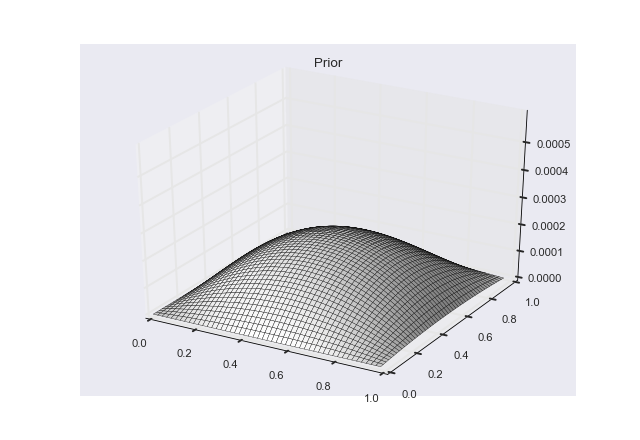

In [18]:
#prior
pr = np.zeros((N, N))
for c, t1 in enumerate(theta):
    for r, t2 in enumerate(theta):
        pr[r, c] = prior_bern(t1, a1, b1) * prior_bern(t2, a2, b2)
pr /= sum(sum(pr))


fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(theta, theta)
ax.plot_surface(X, Y, pr, rstride=2, cstride=2, color='w')
ax.set_zlim3d(0, 0.0006)
plt.title('Prior')
plt.show()

<IPython.core.display.Javascript object>


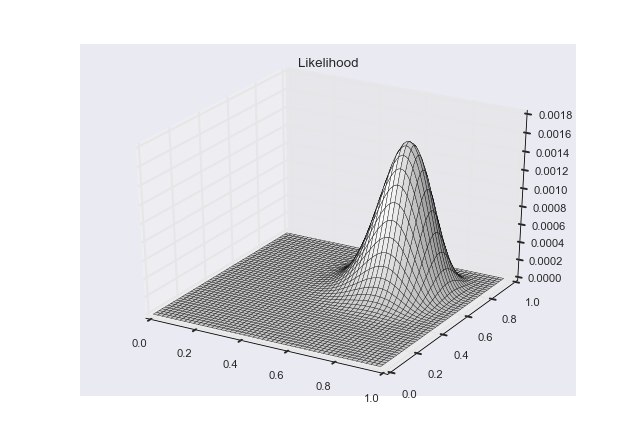

In [19]:
# likelihood

z = sum(data)
n = len(data) 

lh = np.zeros((N, N))
for c, t1 in enumerate(theta):
    for r, t2 in enumerate(theta):
        lh[r, c] = likelihood_bern(t1, z, n) * likelihood_bern(t2, z, n)
lh /= sum(sum(lh))


fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(theta, theta)
ax.plot_surface(X, Y, lh, rstride=2, cstride=2, color='w')
plt.title('Likelihood')
plt.show()

7.4.2 Posterior via the Metropolis Algorithm

In [20]:
t1, t2 = 0.5, 0.5

data1 = np.array([0]*6 + [1]*14)
data2 = np.array([0]*14 + [1]*6)

   
path = []

steps = 20000
burn_in = 1000
sigma=.2
for i in range(steps + burn_in):
    t1_jump = t1 + randn()*sigma
    t2_jump = t2 + randn()*sigma
    
    prob_jump = (rel_prob_bern(t1_jump, data1, a1, b1) *
                 rel_prob_bern(t2_jump, data2, a2, b2))
    prob_curr = (rel_prob_bern(t1, data1, a1, b1) *
                 rel_prob_bern(t2, data2, a2, b2))
    prob_curr = max(prob_curr, 1.e-80)
    
    p_move = min(1, prob_jump / prob_curr)
    if uniform() < p_move:
        t1 = t1_jump
        t2 = t2_jump
    if i >= burn_in:
        path.append([t1, t2])

<IPython.core.display.Javascript object>


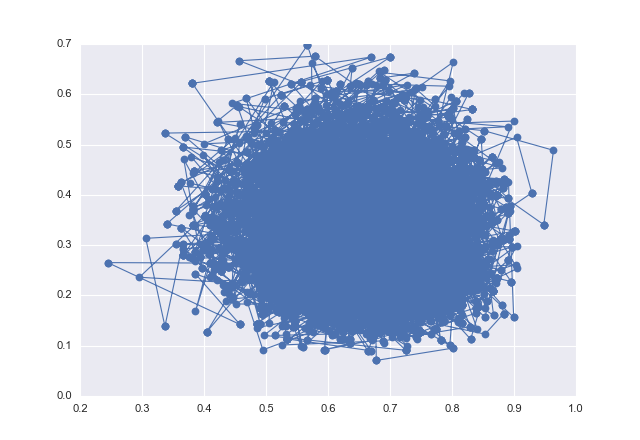

In [21]:
path = np.asarray(path)
np.mean(path, axis=0)
plt.figure()
plt.plot(path[:, 0], path[:, 1], lw=1, marker='o');